## Script responsável por realizar o tratamento dos dados e a análise descritiva

- Este código pressupõe que os arquivos do DOU estejam descompactados e se encontrem no arquivo **./saida/01_DOUSecao02_completo.parquet**
- Caso não exista, ele pode ser gerado por meio do notebook **01_DOU_LerZips.ipynb**
- Processamento deste script:
  - Faz a leitura do arquivo **./saida/01_DOUSecao02_completo.parquet**
  - Filtra apenas portarias
  - Filtra apenas portarias do MGI
  - Cria a coluna Texto a partir da TextHTML, removento das tags html do corpo da portaria
  - Cria a coluna Total_palavras, que exibe o total de palavras da coluna Texto
  - Cria a coluna Ano com o ano da publicação (pubDate)
  - Cria a coluna Mês com o mês da publicação (pubDate)
  - Salva a saída parcial no arquivo **.\saida\02_DouSecao0<No Seção>_portarias_mgi_tratado.parquet** 
 
---


## Biblioteca

In [8]:
# Bibliotecas para manipulação e análise de dados
import pandas as pd

# Biblioteca para processamento de texto e HTML/XML
from bs4 import BeautifulSoup
import string  # Para manipulação de caracteres e strings

# Biblioteca para medir o tempo de execução
import time

# Biblioteca para visualização de dados
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

## 01 - Tratamento dos dados

In [2]:
# Função para contar palavras desconsiderando a pontuação
def contar_palavras(texto):
    # Remover pontuação
    texto_sem_pontuacao = texto.translate(str.maketrans('', '', string.punctuation))
    # Dividir o texto em palavras
    palavras = texto_sem_pontuacao.split()
    # Retornar a contagem de palavras
    return len(palavras)

In [3]:
# Função para extrair o texto de um texto HTML
def extract_text_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text(separator=' ')

In [4]:
douItem = 2
secao = f'Secao0{douItem}'

In [ ]:
# Lê o arquivo Parquet
df = pd.read_parquet(f'./saida/01_DOU{secao}_completo.parquet', engine='pyarrow')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df.shape


In [ ]:
# Converte a coluna pubDate para datetime
df['pubDate'] = pd.to_datetime(df['pubDate'], format='%d/%m/%Y', errors='coerce')

# Extrair ano e mês
df.loc[:, 'Ano'] = df['pubDate'].dt.year
df.loc[:, 'Mes'] = df['pubDate'].dt.month

In [ ]:
df_portaria = df[df['artType'] == 'Portaria']

df_portaria.shape

In [ ]:
# Filtrar os valores que contenham "ministério da inovação" na coluna 'artCategory', ignorando case
filtro = df_portaria['artCategory'].str.contains("Ministério da Gestão e da Inovação em Serviços Público", case=False, na=False)
df_portarias_mgi = df_portaria[filtro]

# Exibir o DataFrame filtrado
df_portarias_mgi.shape

In [ ]:
# Início do cronômetro
start_time = time.time()

# Garantir que estamos trabalhando com uma cópia explícita
df_portarias_mgi = df_portarias_mgi.copy()

# Cria uma coluna 'Texto' com o texto sem as tagas de HTML
df_portarias_mgi.loc[:, 'Texto'] = df_portarias_mgi['TextoHTML'].apply(extract_text_from_html)

# Cria uma coluna 'Total_palavras' com o total de palavras da coluna Texto
df_portarias_mgi.loc[:, 'Total_palavras'] = df_portarias_mgi['Texto'].apply(contar_palavras)

# Exibe o shape do DataFrame final
print(df_portarias_mgi.shape)

# Fim do cronômetro
end_time = time.time()

# Exibir o tempo de execução
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time:.2f} segundos")

In [ ]:
# Salva saída parcial o arquivo completo com novas colunas
df_portarias_mgi.to_parquet(f'./saida/02_DOU{secao}_portarias_mgi_tratado.parquet', engine='pyarrow', index=False)

In [ ]:
df_portarias_mgi.head()

## 02 - Análise descritiva

In [2]:
douItem = 2
secao = f'Secao0{douItem}'

# Lê o arquivo Parquet
df_portarias_mgi = pd.read_parquet(f'./saida/02_DOU{secao}_portarias_mgi_tratado.parquet', engine='pyarrow')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df_portarias_mgi.shape

(19258, 31)

In [ ]:
import pandas as pd

# Contar total geral por Ano
total_geral = df.groupby('Ano').size().reset_index(name='TotalGeral')

# Contar total de portarias por Ano
total_portaria = df_portaria.groupby('Ano').size().reset_index(name='TotalPortaria')

# Contar total de portarias do MGI por Ano
total_portaria_mgi = df_portarias_mgi.groupby('Ano').size().reset_index(name='TotalPortariaMGI')

# Unir os resultados em um único DataFrame
resultado = total_geral.merge(total_portaria, on='Ano', how='left').merge(total_portaria_mgi, on='Ano', how='left')

# Substituir valores NaN por 0 para anos sem registros em alguma categoria
resultado.fillna(0, inplace=True)

# Garantir que as colunas estão no formato inteiro
resultado['Ano'] = resultado['Ano'].astype(int)
resultado[['TotalGeral', 'TotalPortaria', 'TotalPortariaMGI']] = resultado[['TotalGeral', 'TotalPortaria', 'TotalPortariaMGI']].astype(int)

# Exibir o resultado final
resultado.head()

In [ ]:
# Verifica as portarias publicadas considrando Ministério da Economia e MGI

# Filtrar registros com artType = "Portaria"
filtro_portaria = df['artType'].str.lower() == "portaria"

# Filtrar registros do ano de 2023
filtro_ano = df['Ano'] == 2023

# Verificar registros com "Ministério da Economia" em artCategory, ignorando case
filtro_economia = df['artCategory'].str.contains("Ministério da Economia", case=False, na=False)

# Verificar registros com "Ministério da Gestão e da Inovação" em artCategory, ignorando case
filtro_gestao = df['artCategory'].str.contains("Ministério da Gestão e da Inovação", case=False, na=False)

# Combinar os filtros para cada categoria no ano de 2023 e com artType = "Portaria"
filtro_economia_2023 = filtro_portaria & filtro_ano & filtro_economia
filtro_gestao_2023 = filtro_portaria & filtro_ano & filtro_gestao

# Quantidade de registros com "Ministério da Economia" em 2023
qtde_economia_2023 = df.loc[filtro_economia_2023].shape[0]

# Quantidade de registros com "Ministério da Gestão e da Inovação" em 2023
qtde_gestao_2023 = df.loc[filtro_gestao_2023].shape[0]

# Quantidade total de registros de "Portaria" em 2023
qtde_total_2023 = df.loc[filtro_portaria & filtro_ano].shape[0]

# Exibir os resultados
print(f"Quantidade de registros de 'Portaria' com 'Ministério da Economia' em 2023: {qtde_economia_2023}")
print(f"Quantidade de registros de 'Portaria' com 'Ministério da Gestão e da Inovação' em 2023: {qtde_gestao_2023}")
print(f"Quantidade total de registros de 'Portaria' em 2023: {qtde_total_2023}")


In [ ]:
# Análise descritiva na qtde de palavras da coluna Texto

# Garantir que a coluna Total_palavras seja numérica
df_portarias_mgi['Total_palavras'] = pd.to_numeric(df_portarias_mgi['Total_palavras'], errors='coerce')

# Calcular as estatísticas
menor_qtde = df_portarias_mgi['Total_palavras'].min()
media = df_portarias_mgi['Total_palavras'].mean()
mediana = df_portarias_mgi['Total_palavras'].median()
maximo = df_portarias_mgi['Total_palavras'].max()

# Exibir os resultados
print(f"Menor quantidade de palavras: {menor_qtde}")
print(f"Média de palavras: {media}")
print(f"Mediana de palavras: {mediana}")
print(f"Maior quantidade de palavras: {maximo}")


In [ ]:
# Garantir que a coluna Total_palavras seja numérica
df_portarias_mgi['Total_palavras'] = pd.to_numeric(df_portarias_mgi['Total_palavras'], errors='coerce')

# Definir intervalos para o eixo X (de 0 a 2100, com bins de 100)
bins = list(range(0, 800, 100))

# Criar a distribuição agrupada por intervalos
word_count_distribution = pd.cut(df_portarias_mgi['Total_palavras'], bins=bins).value_counts(sort=False)

# Criar o gráfico de barras com a quantidade de documentos exibida
plt.figure(figsize=(12, 6))
bars = plt.bar(word_count_distribution.index.astype(str), word_count_distribution.values, 
               color='skyblue', edgecolor='black')

# Adicionar a quantidade de documentos como texto acima de cada barra
for bar in bars:
    height = bar.get_height()
    if height > 0:  # Exibe apenas se houver documentos no bin
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
                 ha='center', va='bottom', fontsize=10)

# Configurações do gráfico
plt.title("Distribuição do Número de Palavras por Intervalos de 100", fontsize=16)
plt.xlabel("Intervalos de Quantidade de Palavras por Documento", fontsize=14)
plt.ylabel("Número de Documentos", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
total_portaria_mgi = df_portarias_mgi.groupby('Ano').size().reset_index(name='TotalPortariaMGI')
print(total_portaria_mgi)

In [ ]:
df_portarias_mgi.shape

In [3]:
# Verificar se a coluna "Total_palavras" existe no DataFrame
if 'Total_palavras' in df_portarias_mgi.columns:
    # Filtrar registros com até 512 palavras
    registros_ate_512 = df_portarias_mgi[df_portarias_mgi['Total_palavras'] <= 512]
    
    # Contar o total de registros que atendem ao critério
    total_registros_ate_512 = len(registros_ate_512)
    
    print(f"Total de registros com até 512 palavras: {total_registros_ate_512}")
else:
    print("Erro: A coluna 'Total_palavras' não foi encontrada no DataFrame.")


Total de registros com até 512 palavras: 18795


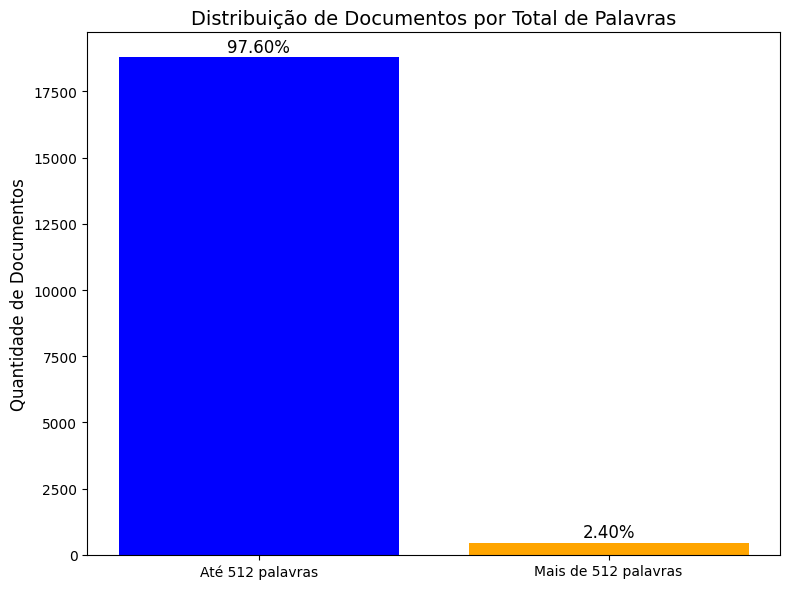

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que o DataFrame df_portarias_mgi já exista
# df_portarias_mgi['Total_palavras'] contém o total de palavras por documento

# Calcular a quantidade de documentos com até 512 palavras
total_documentos = len(df_portarias_mgi)
documentos_ate_512 = df_portarias_mgi[df_portarias_mgi['Total_palavras'] <= 512]
percentual_ate_512 = len(documentos_ate_512) / total_documentos * 100

# Preparar os dados para o gráfico
categorias = ['Até 512 palavras', 'Mais de 512 palavras']
quantidades = [len(documentos_ate_512), total_documentos - len(documentos_ate_512)]

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(categorias, quantidades, color=['blue', 'orange'])

# Adicionar rótulos e título
plt.title('Distribuição de Documentos por Total de Palavras', fontsize=14)
plt.ylabel('Quantidade de Documentos', fontsize=12)
plt.text(0, quantidades[0] + total_documentos * 0.01, f'{percentual_ate_512:.2f}%', ha='center', fontsize=12)
plt.text(1, quantidades[1] + total_documentos * 0.01, f'{100 - percentual_ate_512:.2f}%', ha='center', fontsize=12)

# Exibir o gráfico
plt.tight_layout()
plt.show()


In [16]:
# Lê o arquivo Parquet
df_portarias_mgi = pd.read_parquet(f'./saida/03_3_DOU{secao}_portarias_mgi_tratado_NER_lematizado.parquet')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df_portarias_mgi.shape


(19258, 39)

In [17]:
df_portarias_mgi.head()

,id,name,idOficio,pubName,artType,pubDate,artClass,artCategory,artSize,artNotes,...,Texto,Total_palavras,TextoTratado,TextoTratado_TotalPalavras,Texto_sem_nomes,Nomes,TextoTratadoSemNomes,TextoTratadoSemNomes_TotalPalavras,TextoTratadoSemNomesLemmatized,TextoTratadoSemNomesLemmatized_TotalPalavras
0,30266027,PORTARIA DE PESSOAL 529,9368436,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 529, DE 17...",358,"sgp/sedgg/me nº 529, 17 janeiro 2023 secretari...",231,None,"sergio eduardo arbulu, anderson pereira silvy,...","sgp / sedgg / me nº 529 , 17 janeiro 2023 secr...",268,sgp Sedgg nº 529 17 janeiro 2023 secretario ge...,182
1,30264410,ATO PORTARIA 655,9368530,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"PORTARIA SGP/SEDGG/ME Nº 655, DE 23 DE JANEIRO...",245,"portaria sgp/sedgg/me nº 655, 23 janeiro 2023 ...",158,None,"eliane araujo franklin, eduardo arbulu","portaria sgp / sedgg / me nº 655 , 23 janeiro ...",189,portar sgp Sedgg nº 655 23 janeiro 2023 secret...,127
2,30265009,ATO PORTARIA DE PESSOAL 461,9368536,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 461, DE 16...",251,"sgp/sedgg/me nº 461, 16 janeiro 2023 secretari...",160,None,eduardo arbulu,"sgp / sedgg / me nº 461 , 16 janeiro 2023 secr...",197,sgp Sedgg nº 461 16 janeiro 2023 secretario ge...,132
3,30265678,ATO PORTARIA DE PESSOAL SGP 606,9368541,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 606, DE 19...",251,"sgp/sedgg/me nº 606, 19 janeiro 2023 secretari...",158,None,eduardo arbulu,"sgp / sedgg / me nº 606 , 19 janeiro 2023 secr...",187,sgp Sedgg nº 606 19 janeiro 2023 secretario ge...,134
4,30266030,ATO PORTARIA DE PESSOAL SGP 517,9368573,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 517, DE 17...",243,"sgp/sedgg/me nº 517, 17 janeiro 2023 secretari...",158,None,"roberto jorge ferreira, termino exercicio, edu...","sgp / sedgg / me nº 517 , 17 janeiro 2023 secr...",177,sgp Sedgg nº 517 17 janeiro 2023 secretario ge...,122


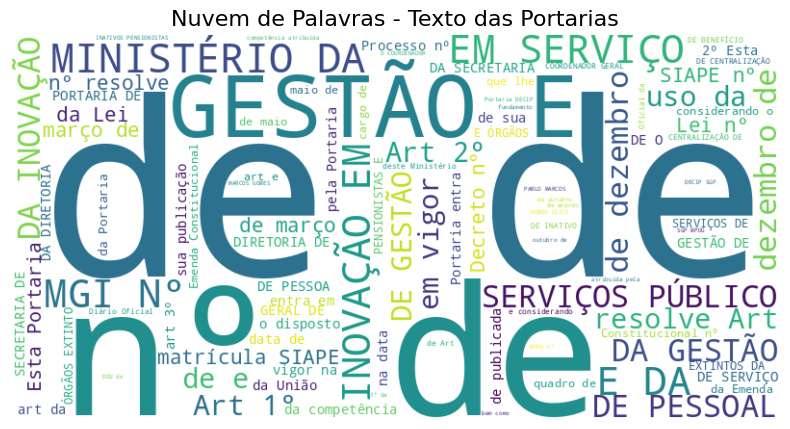

In [31]:
# Texto consolidado de todas as portarias
texto_consolidado = " ".join(df_portarias_mgi['Texto'].dropna())

texto_consolidado = texto_consolidado.strip()  # Remover espaços extras
texto_consolidado = texto_consolidado.replace("\n", " ")  # Substituir quebras de linha
texto_consolidado = texto_consolidado.replace(",", "")  # Remover pontuação

# Palavras irrelevantes (stop words) adicionais, se necessário
stopwords = set(STOPWORDS)
# stopwords.update(["de"])  # Adicione palavras comuns do contexto jurídico

# Gerar a nuvem de palavras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    max_words=100,  # Número máximo de palavras na nuvem
    colormap='viridis'  # Escolha do esquema de cores
).generate(texto_consolidado)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar os eixos
plt.title("Nuvem de Palavras - Texto das Portarias", fontsize=16)
plt.show()


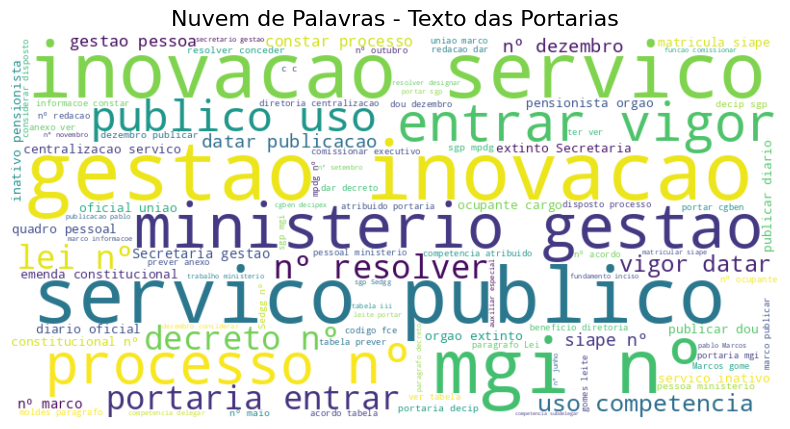

In [30]:
# Texto consolidado de todas as portarias
texto_consolidado = " ".join(df_portarias_mgi['TextoTratadoSemNomesLemmatized'].dropna())

texto_consolidado = texto_consolidado.strip()  # Remover espaços extras
texto_consolidado = texto_consolidado.replace("\n", " ")  # Substituir quebras de linha
texto_consolidado = texto_consolidado.replace(",", "")  # Remover pontuação

# Palavras irrelevantes (stop words) adicionais, se necessário
stopwords = set(STOPWORDS)
# stopwords.update(["inovacao"])  # Adicione palavras comuns do contexto jurídico

# Gerar a nuvem de palavras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    max_words=100,  # Número máximo de palavras na nuvem
    colormap='viridis'  # Escolha do esquema de cores
).generate(texto_consolidado)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar os eixos
plt.title("Nuvem de Palavras - Texto das Portarias", fontsize=16)
plt.show()


In [21]:
wordcloud